# <a href="https://colab.research.google.com/github/tvml/ml2021/blob/main/codici/BetaBernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sequenza di plot della distribuzione a posteriori del parametro di una distribuzione di Bernoulli al crescere del numero di osservazioni (lanci di moneta)

In [4]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [7]:
datadict = {
    "a": np.random.randn(100),
    "b": np.random.randn(1, 100, 10),
    "c": np.random.randn(1, 100, 3, 4),
}
dataset = az.convert_to_inference_data(datadict)
dataset.posterior.c

<xarray.DataArray 'c' (chain: 1, draw: 100, c_dim_0: 3, c_dim_1: 4)>
array([[[[-1.393794  , -2.24046668, -1.34180448, -0.35166701],
         [ 1.66231452,  0.09547119, -0.74459188, -0.18842537],
         [-1.26240224,  1.34166471,  0.09509812, -1.94560772]],

        [[-0.15811534,  0.92345184, -0.17425048, -0.42160663],
         [-0.20158444, -0.08702899, -0.12446226, -0.03838284],
         [-0.0493468 ,  0.95988172, -0.44308199,  0.75460166]],

        [[-0.94736188,  0.40719813, -1.21575704,  1.109172  ],
         [ 1.69209914,  1.3750239 , -1.79929969,  1.373437  ],
         [-0.45691262, -0.27229081,  0.3074916 ,  2.41437281]],

        ...,

        [[ 0.9730378 ,  0.41659083,  1.43537256,  0.62027203],
         [ 0.08085315, -0.70113884, -1.15113414,  1.11229347],
         [ 0.21784205,  0.00692347, -1.33855151, -1.34098368]],

        [[-0.18223909,  0.36004057,  1.03390199, -0.38856525],
         [-0.64691043, -0.83907279, -0.82988043, -1.46154803],
         [-0.36989096, -0.811616  , -1.55613088,  1.13799953]],

        [[ 0.89253703, -1.01759056,  0.50221617, -0.01683174],
         [ 0.27680775,  0.47983041, -0.68057361, -0.82488234],
         [ 0.28897779, -2.14564385, -0.13845204, -0.12168518]]]])
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * c_dim_0  (c_dim_0) int64 0 1 2
  * c_dim_1  (c_dim_1) int64 0 1 2 3

Fissa la probabilità $\theta$ di esito pari a $1$ e i numeri di osservazioni da considerare

In [8]:
theta_real = 0.36
n_trials = 100000

Genera la sequenza casuale di risultati derivanti da lanci ripetuti con probabilità di $1$ pari a $\theta$

In [9]:
data = stats.bernoulli.rvs(theta_real, size=n_trials)

In [10]:
data

array([1, 1, 1, ..., 0, 0, 0])

Fissa la distribuzione a priori del parametro $\theta$. Si utilizza un modello Beta-Bernoulli, per cui la prior (e di conseguenza la posterior) sono distribuzioni Beta. 

![Diagramma modello beta-bernoulli.](assets/betabernoulli.png)

In [11]:
# dichiara la distribuzione prior
dist = stats.beta
# valori dei suoi parametri
alpha = 100
beta = 100
hyper = [alpha, beta]

Calcola i valori della densità di probabilità a priori su una griglia ($1$-dimensionale) di punti

In [12]:
# fissa l'insieme dei valori sui quali calcolare la distribuzione
nv = 100000
x = np.linspace(0, 1, nv)
# calcola i valori di densità di probabilità per tutti i punti dell'insieme
yp = dist.pdf(x,*hyper)

Plot della distribuzione a priori di $\theta$

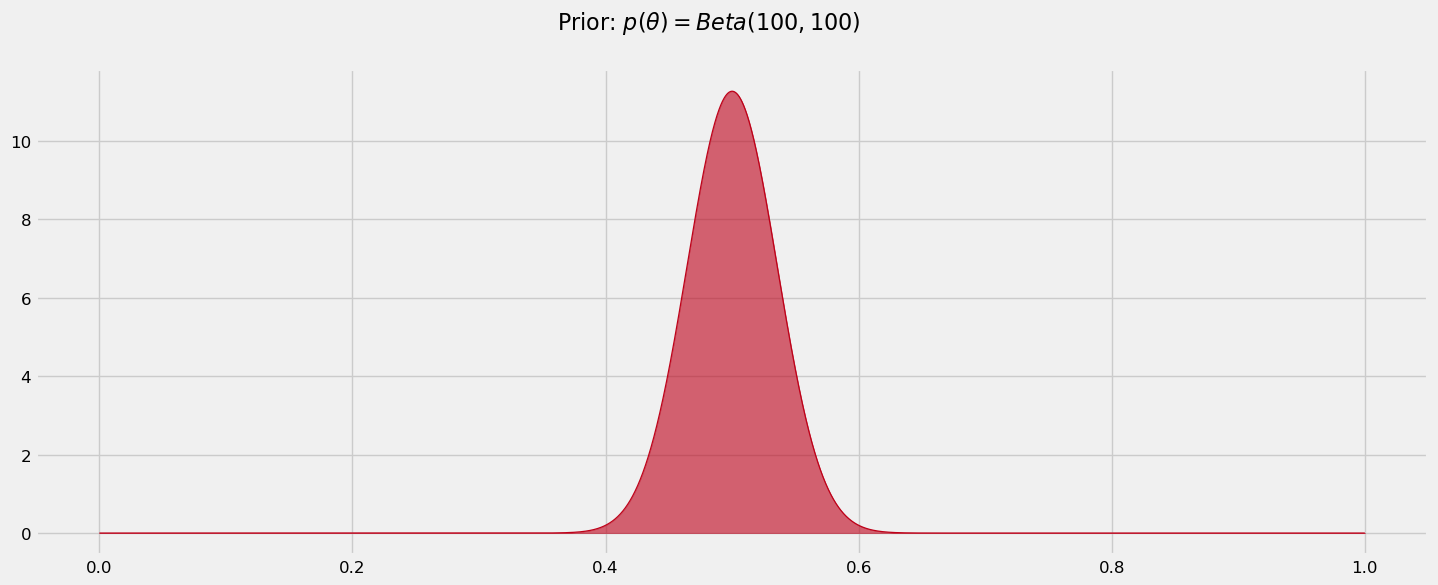

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
ax=plt.subplot(1,1,1)
ax.plot(x, yp, '-', c=colors[7], linewidth=0.9, alpha=1, label="prior")
ax.fill_between(x, 0, yp, color=colors[7], alpha=0.6)
# testo sull'asse x
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout
# titolo della figura
plt.suptitle(r'Prior: $p(\theta)=Beta({0:3d}, {1:3d})$'.format(alpha, beta), fontsize=16)
plt.show()

Per ogni numero di osservazioni fissato, determina il numero di valori $1$ osservati, calcola i parametri della distribuzione a posteriori risultante e memorizza il valore della verosimiglianza e della densità di probabilità per tutti i punti della griglia.

In [14]:
n = 500

In [15]:
# determina numero di esiti pari a 1
ones = data[:n].sum()
# modifica i parametri della distribuzione per tener conto degli esiti osservati
params = [sum(t) for t in zip(hyper, [ones, n-ones])]
# calcola elenco dei valori per la distribuzione a posteriori con i parametri calcolati
post = dist.pdf(x, *params)
# calcola il valore sulla griglia per cui la distribuzione a posteriori è massima
mp = x[np.argmax(post)]
# calcola elenco dei valori per la verosimiglianza con la probabilità considerata
lik = [p**ones*(1-p)**(n-ones) for p in x]
# calcola il valore sulla griglia per cui la verosimiglianza è massima
ml = x[np.argmax(lik)]
# calcola il valore dell'evidenza
ev = np.sum(list(map(lambda x,y:x*y/float(nv), lik, yp)))

Visualizza la distribuzione a priori, la verosimiglianza e la distribuzione a posteriori per il numero di osservazioni considerato

In [16]:
def plot_dist():
    fig, ax = plt.subplots(figsize=(16,10))
    ax=plt.subplot(2,1,1)
    ax.plot(x, lik, '-', c=colors[1], linewidth=0.9, alpha=0.8)
    # riempie la zona compresa tra la curva e l'asse x
    ax.fill_between(x, 0, lik, color=colors[1], alpha=0.3)
    # testo sull'asse x
    plt.xlabel(r"$\theta$",fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Likelihood; ML={0:8.5f}'.format(ml), fontsize=14)
    ax=plt.subplot(2,1,2)
    # effettua il plot a partire dalla sequenza di ascisse in x e di ordinate calcolate e salvate 
    # nell'elemento attuale di ys
    ax.plot(x, post, '-', c=colors[3], linewidth=0.9, alpha=1)
    # riempie la zona compresa tra la curva e l'asse x
    ax.fill_between(x, 0, post, color=colors[3], alpha=0.6)
    # effettua il plot del prior a partire dalla sequenza di ascisse in x e di ordinate calcolate e salvate in yp
    ax.plot(x, yp, '-', c=colors[7], linewidth=0.9, alpha=1, label="prior")
     # riempie la zona compresa tra la curva e l'asse x
    ax.fill_between(x, 0, yp, color=colors[7], alpha=0.6)
    plt.annotate(r'Evidence; $p(X)={0:10.3e}$'.format(ev), xy=(.05, .85), va='top', xycoords='axes fraction', 
                 fontsize=14)
    # testo sull'asse x
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(r'Posterior; $p(\theta|X)=Beta({0:3d}, {1:3d})\qquad$ MAP={2:8.5f}'.format(params[0],params[1],mp), fontsize=14)
    #plt.tight_layout
    # titolo della figura
    plt.suptitle(r'$\theta={0:3.2f}\qquad n={1:3d}\qquad\#1={2:3d}\quad \#0={3:3d}$'.format(theta_real, 
                                                    n, ones, n-ones), fontsize=16)
    plt.show()

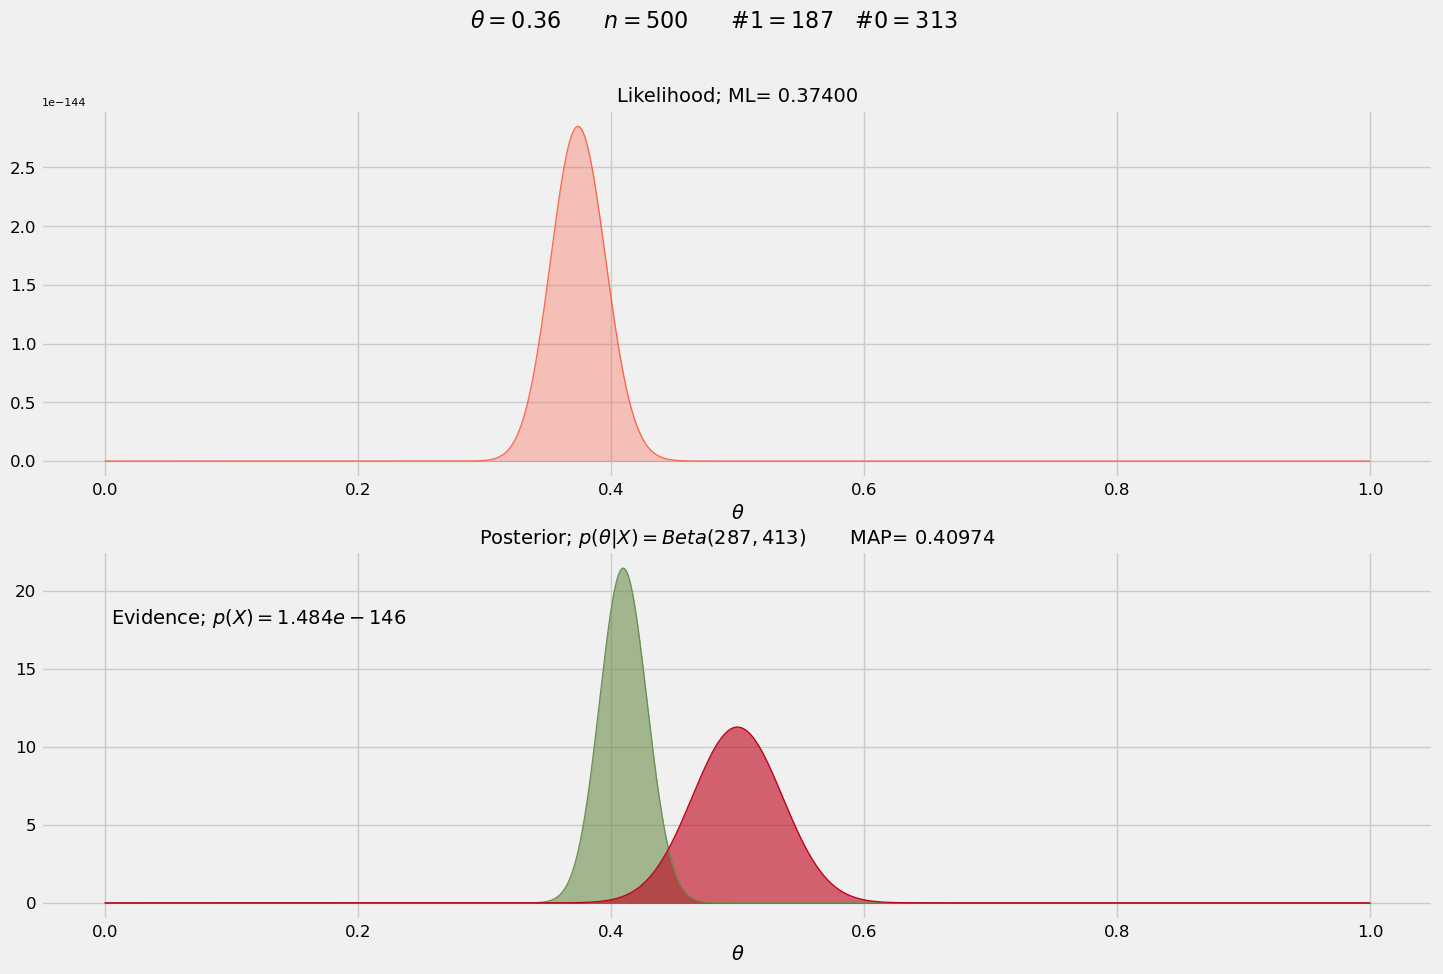

In [17]:
plot_dist()

In [18]:
with pm.Model() as model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(5000, chains=2)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 1 chain for 1_000 tune and 589 draw iterations (1_000 + 589 draws total) took 35 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [97]:
pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive
    )

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

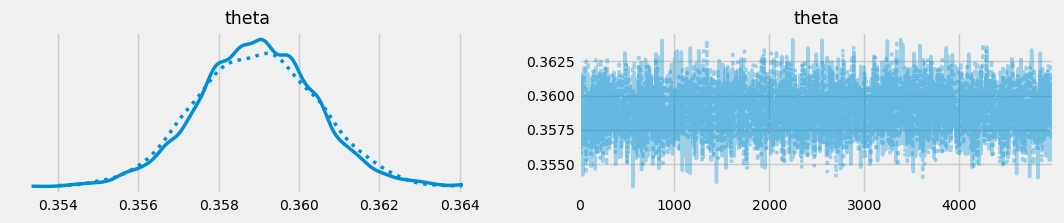

In [98]:
az.plot_trace(pm_data, var_names=("theta"))

<AxesSubplot:title={'center':'theta'}>

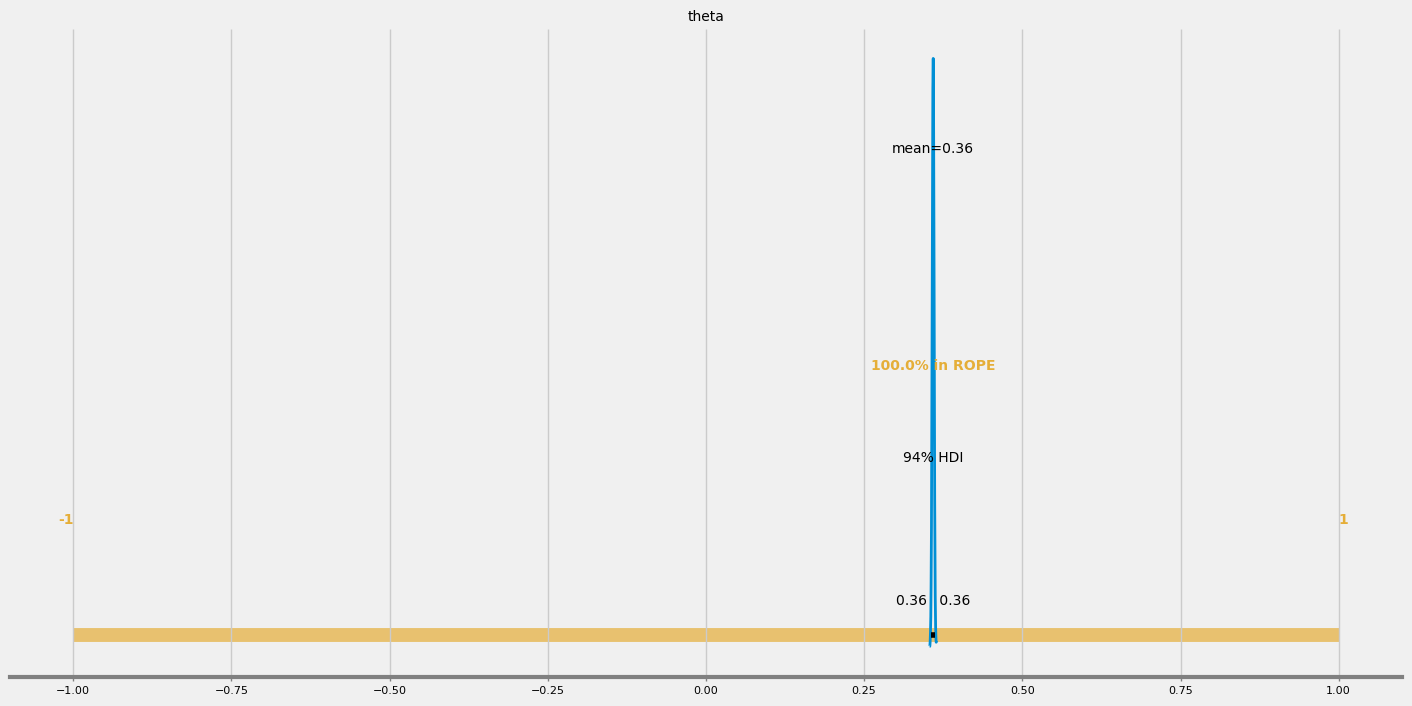

In [99]:
az.plot_posterior(pm_data, var_names=["theta"], rope=(-1, 1))

In [100]:
theta_data = data.sum()/len(data)

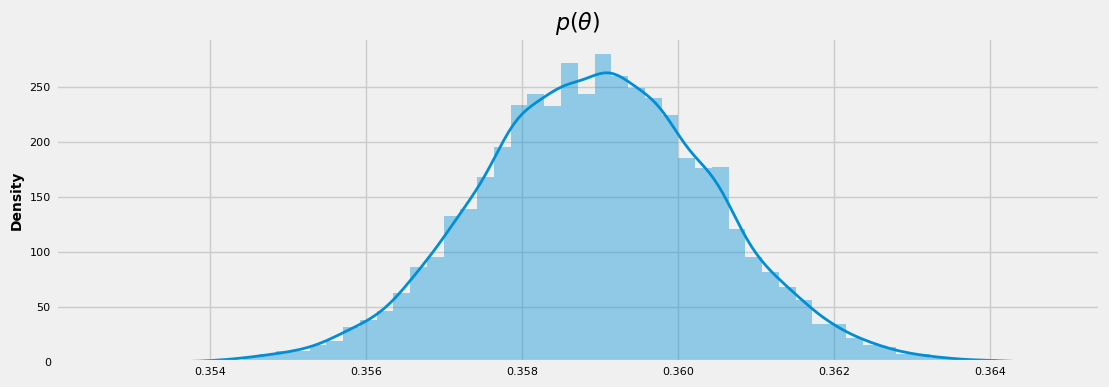

In [101]:
fig = plt.figure(figsize=(12,4))
sns.distplot(trace['theta'])
plt.title(r'$p(\theta)$', fontsize=16)
plt.show()

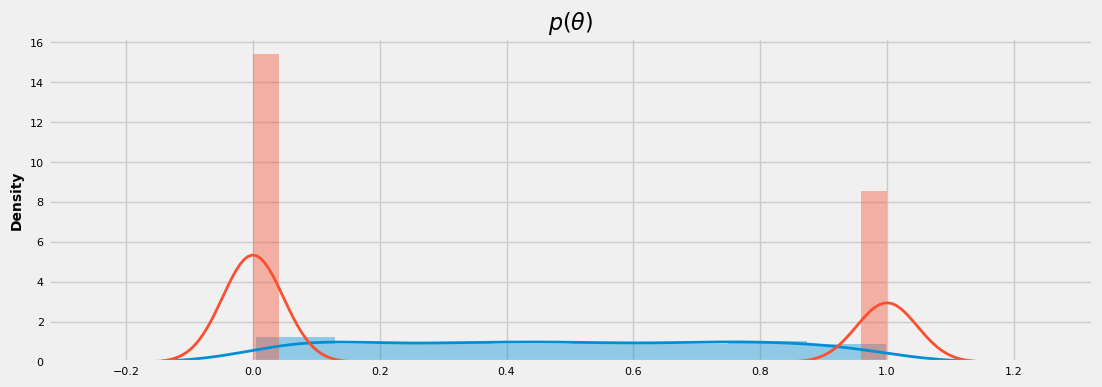

In [102]:
fig = plt.figure(figsize=(12,4))
sns.distplot(prior['theta'])
sns.distplot(posterior_predictive['y'][200])
plt.title(r'$p(\theta)$', fontsize=16)
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

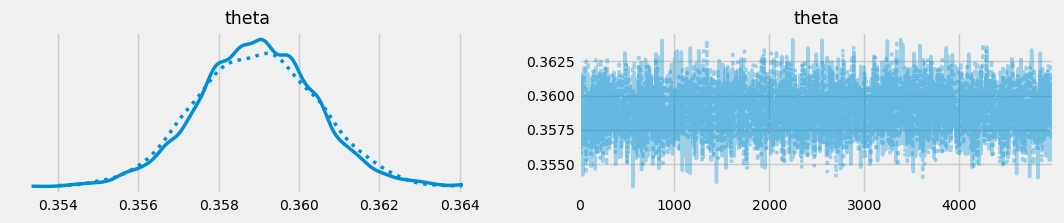

In [103]:
pm.traceplot(trace, lines={'theta':theta_data})

In [40]:
with model:
    multi_trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1880.43draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1efb6400>,
      dtype=object)

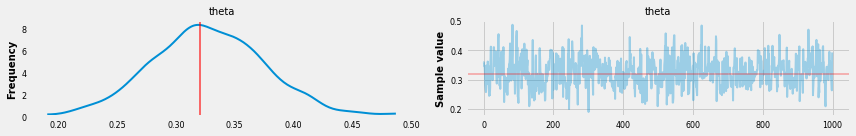

In [28]:
pm.traceplot(multi_trace, lines={'theta':theta_data})

In [29]:
pm.summary(multi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta,0.327161,0.047773,0.002238,0.233053,0.418637


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f089320>]],
      dtype=object)

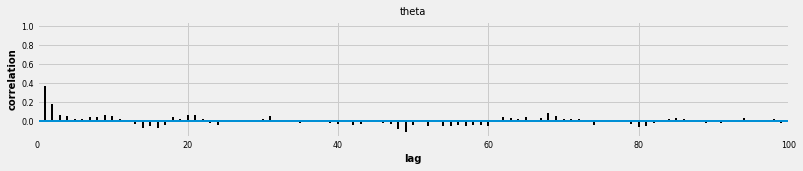

In [30]:
pm.autocorrplot(multi_trace)

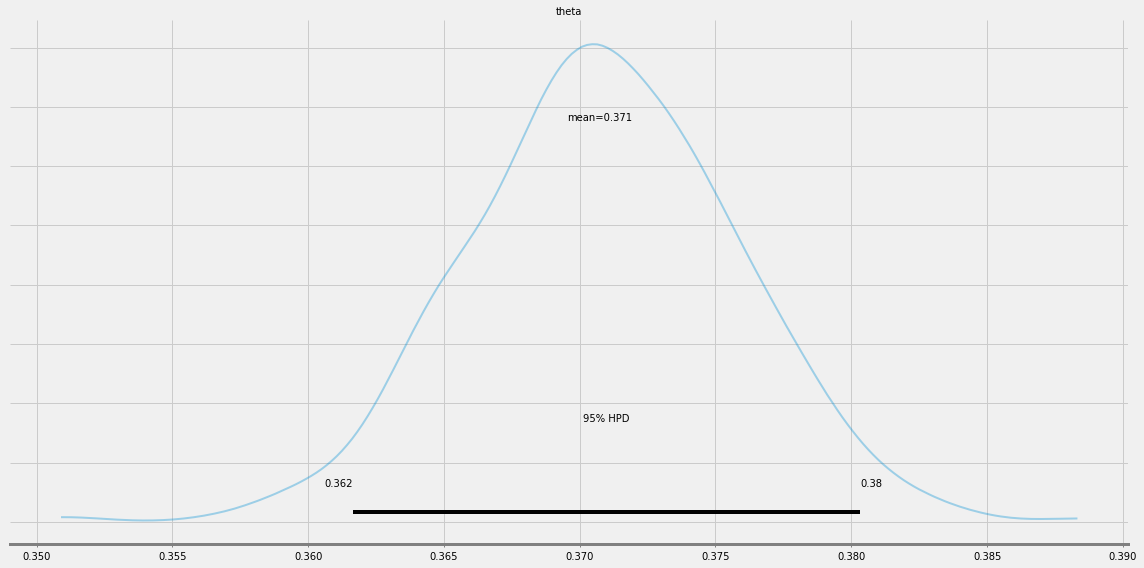

In [226]:
pm.plot_posterior(multi_trace, kde_plot=True)